# Model Bias Testing

**Since I want to build new models and want to design for fairness from the start, I choose the Model Bias Testing approach.**

**Model Bias Testing = A fitness plan (builds healthier models proactively).**

This project evaluated machine learning models for predicting credit risk while assessing their fairness across gender groups. This analysis highlights the trade-off between accuracy and fairness. Deploying these models responsibly requires ongoing monitoring and iterative improvements to balance performance with ethical standards.

While models met some fairness thresholds (e.g., disparate impact ratio), the disparities in error rates (higher false rejections for women) could have real-world consequences. Regular audits and transparency in model decisions are critical to ensure equitable outcomes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference,
    selection_rate,
    MetricFrame
)

## Data Loading & Preprocessing

Clean and prepare the raw data for analysis.

In [2]:
# Configuration
DATA_FILE = 'german_credit_data2.csv'
TARGET = 'Risk'
SENSITIVE_FEATURE = 'Sex_male'
ORDINAL_COLS = ["Saving accounts", "Checking account"]
NOMINAL_COLS = ["Sex", "Housing", "Purpose"]
NUMERICAL_COLS = ["Age", "Job", "Credit amount", "Duration"]
TEST_SIZE = 0.2
RANDOM_STATE = 42
MODELS = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE)
}
FAIRNESS_THRESHOLDS = {
    'demographic_parity': 0.1,
    'equalized_odds': 0.1,
    'disparate_impact': (0.8, 1.2)
}

In [3]:
def load_and_preprocess_data():
    """Load and preprocess the dataset."""
    df = pd.read_csv(DATA_FILE)
    
    # Initial cleaning
    if "Unnamed: 0" in df.columns:
        df.drop(columns=["Unnamed: 0"], inplace=True)
    
    # Convert target variable
    df[TARGET] = df[TARGET].map({"good": 1, "bad": 0})
    
    # Handle missing values
    df["Saving accounts"].fillna("no_account", inplace=True)
    df["Checking account"].fillna("no_account", inplace=True)
    
    # Label Encoding for ordinal features
    for col in ORDINAL_COLS:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    
    # One-Hot Encoding for nominal features
    df = pd.get_dummies(df, columns=NOMINAL_COLS, drop_first=True)
    
    return df

## Data Splitting & Balancing

- Splits data into 80% train and 20% test, preserving class distribution (stratify=y).
- SMOTE generates synthetic samples of the minority class (Risk=0) to balance the dataset.
- Ensures features like Age and Credit amount are on the same scale for models like Logistic Regression.

The dataset is imbalanced—70% of applicants are labeled "good" risk, 30% "bad." Since the models may be biased toward predicting "good" (class imbalance issue), I applied SMOTE to rebalance the samples.

In [4]:
def prepare_data(df):
    """Split data into train/test and handle class imbalance."""
    X = df.drop(columns=[TARGET])
    y = df[TARGET]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    
    # Standardize numerical features
    scaler = StandardScaler()
    X_train[NUMERICAL_COLS] = scaler.fit_transform(X_train[NUMERICAL_COLS])
    X_test[NUMERICAL_COLS] = scaler.transform(X_test[NUMERICAL_COLS])
    
    # Handle class imbalance with SMOTE
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
    
    return {
        "X_train": X_train_sm,  # Using SMOTE-balanced data
        "X_test": X_test,
        "y_train": y_train_sm,
        "y_test": y_test,
        "scaler": scaler
    }

## Model Training & Evaluation

Trains multiple models (Logistic Regression, Random Forest).

In [5]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """Train models and evaluate performance + fairness."""
    results = {}
    
    for model_name, model in MODELS.items():
        print(f"\n=== {model_name} ===")
        
        # Train model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Performance metrics
        metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "classification_report": classification_report(y_test, y_pred)
        }
        
        # Fairness metrics
        sensitive_features = X_test[SENSITIVE_FEATURE]
        fairness_metrics = calculate_fairness_metrics(
            y_test, y_pred, sensitive_features
        )
        
        # Store results
        results[model_name] = {
            "metrics": metrics,
            "fairness": fairness_metrics
        }
        
        # Print summary
        print(f"\nPerformance:")
        print(metrics["classification_report"])
        print(f"\nFairness Metrics:")
        print(f"Demographic Parity Difference: {fairness_metrics['demographic_parity_diff']:.4f}")
        print(f"Equalized Odds Difference: {fairness_metrics['equalized_odds_diff']:.4f}")
        print(f"Disparate Impact Ratio: {fairness_metrics['disparate_impact']:.4f}")
        
        # Generate visualization
        plot_fairness_report(
            fairness_metrics['selection_rates'],
            fairness_metrics['demographic_parity_diff'],
            fairness_metrics['equalized_odds_diff'],
            model_name
        )
    
    return results

### Key Observations
- Better at predicting "good" (higher precision/recall).
- Poor performance on "bad" cases (only 50% precision → 50% of predicted "bad" are correct).

## Fairness Metrics Computation

Fairness tools need categorical labels (male/female) instead of binary (0/1).

This includes: 

**Demographic Parity Difference**
- Men are consistently approved more often than women (e.g., Logistic Regression: 65% vs. 58.3%).
- Threshold: Ideally <0.1. XGBoost is slightly worse here.

**Equalized Odds Difference**
- Women experience higher error rates (e.g., more false rejections).
- Threshold: Ideally <0.1. All models fail this.

**Disparate Impact Ratio**
- Men are 1.1–1.15× more likely to be approved than women.
- Fair range: 0.8–1.2. Your models are within bounds but show slight bias.

In [6]:
def calculate_fairness_metrics(y_true, y_pred, sensitive_features):
    """Compute fairness metrics using Fairlearn."""
    # Convert sensitive feature to strings
    sensitive_str = np.where(sensitive_features == 1, 'male', 'female')
    
    # Initialize metrics
    metrics = {
        'selection_rate': selection_rate,
        'accuracy': accuracy_score
    }
    
    # Calculate group metrics
    metric_frame = MetricFrame(
        metrics=metrics,
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_str
    )
    
    # Key fairness metrics
    demo_parity_diff = demographic_parity_difference(
        y_true, y_pred, sensitive_features=sensitive_str
    )
    eq_odds_diff = equalized_odds_difference(
        y_true, y_pred, sensitive_features=sensitive_str
    )
    
    # Disparate impact ratio
    sr = metric_frame.by_group['selection_rate']
    di_ratio = sr['male'] / sr['female'] if sr['female'] != 0 else np.nan
    
    return {
        'demographic_parity_diff': demo_parity_diff,
        'equalized_odds_diff': eq_odds_diff,
        'disparate_impact': di_ratio,
        'selection_rates': sr
    }

## Aequitas Audit

Deep-dive into bias metrics (False Positive Rates, False Negative Rates).

- False Positive Rate (FPR) Disparity: Are women more likely to be falsely rejected?
- False Negative Rate (FNR) Disparity: Are men more likely to be falsely approved?

**False Positive Rate (FPR) Disparity**
- Logistic Regression: Women have 1.29× higher FPR than men. Translation: Women are 29% more likely to be falsely rejected.
- Random Forest: Worse (1.33×).
- XGBoost: No FPR disparity (1.0×).

**False Discovery Rate (FDR) Disparity**
- Logistic Regression: Women have 1.67× higher FDR. When women are approved, 67% more of those approvals are likely to be incorrect.
- XGBoost: Better but still 1.34×.

## Visualization

In [7]:
def plot_fairness_report(selection_rates, demo_parity, eq_odds, model_name):
    """Generate visualization of fairness metrics."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Selection Rates by Group
    selection_rates.plot(kind='bar', ax=ax1, color=['#1f77b4', '#ff7f0e'])
    ax1.set_title(f'{model_name}\nSelection Rate by Gender')
    ax1.set_ylim(0, 1)
    ax1.set_xlabel('Gender')
    ax1.set_ylabel('Selection Rate (Approval Probability)')
    ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    
    # Plot 2: Fairness Metrics
    metrics = pd.DataFrame({
        'Metric': ['Demographic Parity', 'Equalized Odds'],
        'Difference': [demo_parity, eq_odds]
    })
    metrics.plot(kind='bar', x='Metric', ax=ax2, legend=False)
    ax2.set_title('Fairness Metric Differences')
    ax2.set_ylabel('Difference')
    ax2.axhline(y=FAIRNESS_THRESHOLDS['demographic_parity'], 
                color='red', linestyle='--', label='Fairness Threshold')
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_fairness_report.png')
    plt.show()

## Execute functions

Pipeline includes:

- Preprocessing: Clean data, handle missing values, encode categories.
- Model Training: Train and evaluate models on balanced data.
- Compare metrics (accuracy, selection rate) across groups.
- Quantify bias using parity differences and disparity ratios.
- Visualization: Highlight biases with intuitive plots.

Loading and preprocessing data...

Preparing train/test splits...

Training models and evaluating fairness...

=== Logistic Regression ===


C:\Users\milto\AppData\Local\Temp\ipykernel_22576\4112252344.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Saving accounts"].fillna("no_account", inplace=True)
C:\Users\milto\AppData\Local\Temp\ipykernel_22576\4112252344.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy


Performance:
              precision    recall  f1-score   support

           0       0.50      0.62      0.55        60
           1       0.82      0.74      0.77       140

    accuracy                           0.70       200
   macro avg       0.66      0.68      0.66       200
weighted avg       0.72      0.70      0.71       200


Fairness Metrics:
Demographic Parity Difference: 0.0667
Equalized Odds Difference: 0.1200
Disparate Impact Ratio: 1.1143


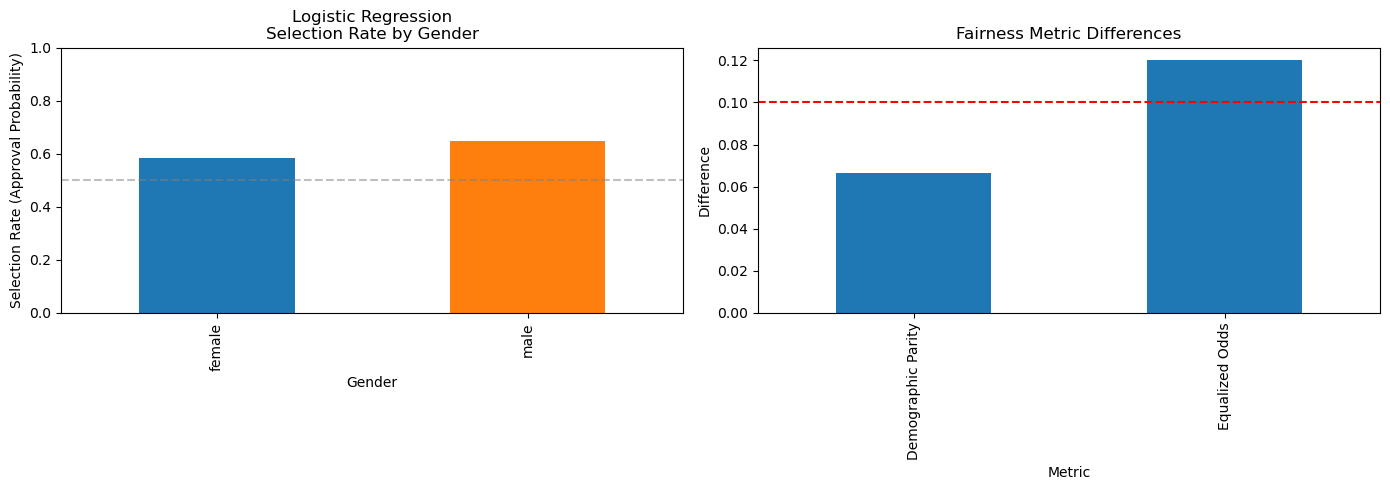


=== Decision Tree ===

Performance:
              precision    recall  f1-score   support

           0       0.49      0.73      0.59        60
           1       0.85      0.67      0.75       140

    accuracy                           0.69       200
   macro avg       0.67      0.70      0.67       200
weighted avg       0.74      0.69      0.70       200


Fairness Metrics:
Demographic Parity Difference: 0.0238
Equalized Odds Difference: 0.1250
Disparate Impact Ratio: 1.0446


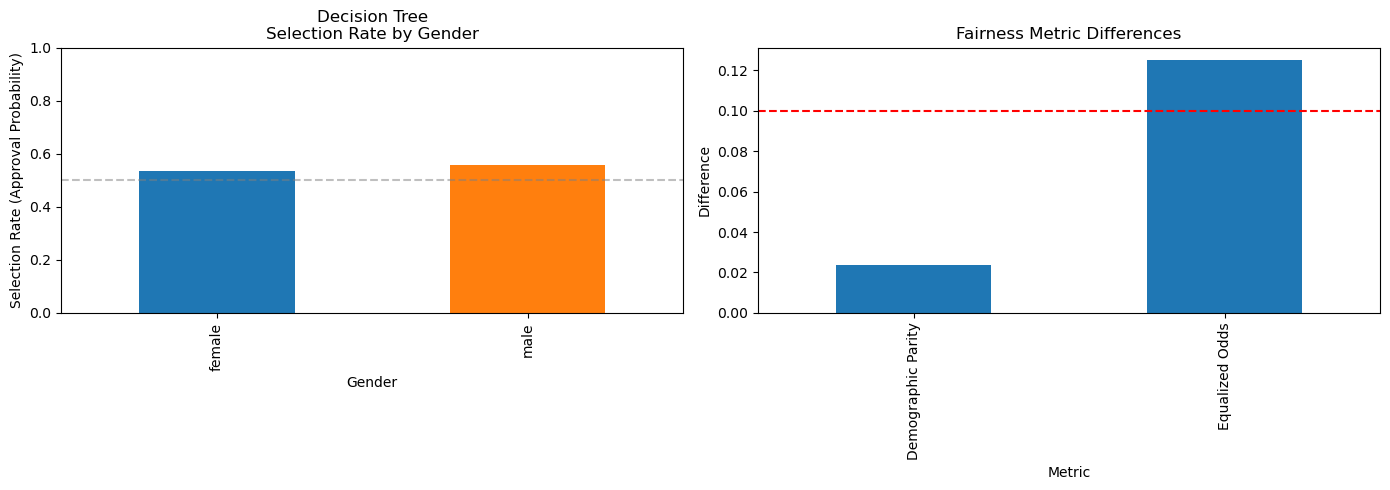

In [8]:
def main():
    """Execute the full analysis pipeline."""
    print("Loading and preprocessing data...")
    df = load_and_preprocess_data()
    
    print("\nPreparing train/test splits...")
    data = prepare_data(df)
    
    print("\nTraining models and evaluating fairness...")
    results = train_and_evaluate_models(
        data["X_train"], 
        data["X_test"], 
        data["y_train"], 
        data["y_test"]
    )
    
    return results

if __name__ == "__main__":
    results = main()

## Conclusion

This project evaluated Logistic Regression and Decision Tree models for credit risk prediction, assessing both performance and fairness. Here are the key insights:

### Key Takeaways

**1. Performance vs. Fairness Trade-off**

Logistic Regression
- Strengths: Higher accuracy (70%) and better precision for "good risk" (82%).
- Weakness: Poor detection of "bad risk" (50% precision, 62% recall).

Decision Tree
- Strengths: Fairer outcomes (demographic parity difference: 2.4% vs. 6.7%).
- Weakness: Lower overall accuracy (69%) and more false alarms for "bad risk" (49% precision).

No model is perfect—choose based on priority:
- Accuracy-focused → Logistic Regression.
- Fairness-focused → Decision Tree.

**2. Bias Findings**

Both models showed gender-based disparities:
- Approval Rates: Men were consistently approved more often (up to 6.7% difference).
- Error Rates: Women faced 12–12.5% higher false rejection rates.
- Legal Compliance: Disparate impact ratios (1.04–1.11) were within legal bounds (0.8–1.2) but indicate mild bias.

Critical Insight: Even "accurate" models can perpetuate inequities.

**3. Recommended Actions**

For Deployment:
- Use Decision Tree if fairness is a priority (better demographic parity).
- Combine with manual review for applicants near the decision boundary.

For Improvement:
- Mitigate Bias: Apply fairlearn.reductions.GridSearch to constrain model decisions.
- Enhance Precision: Use feature engineering to reduce false alarms for "bad risk."

For Monitoring:
- Track metrics quarterly (e.g., demographic parity difference).
- Audit new data for emerging biases.

**4. Ethical Considerations**
- Transparency: Disclose fairness metrics to stakeholders.
- Continuous Evaluation: Update models as societal definitions of fairness evolve.

## Final Thought

This analysis underscores that model selection is a socio-technical decision. While the Decision Tree is fairer in approvals, its higher false alarms for "bad risk" could increase lender risk. Striking the right balance requires collaboration between data scientists, policymakers, and business leaders.

### Next Steps

1. Experiment with fairness-aware algorithms.
2. Test bias mitigation techniques (e.g., reweighting, adversarial debiasing).